In [13]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import Pool
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [3]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('./fotmob_shots.csv')

C:\Users\adamf\AppData\Local\Temp\ipykernel_16024\1980411161.py:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./fotmob_shots.csv')


In [4]:
# View the first few rows of the DataFrame
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
           id     eventType  teamId  playerId            playerName  \
0  2501093133          Miss   10086    918846          Gaston Veron   
1  2501093203  AttemptSaved   10084    751057  Francis Mac Allister   
2  2501093465  AttemptSaved   10086    918846          Gaston Veron   
3  2501093475  AttemptSaved   10086   1035611        Alan Rodriguez   
4  2501095563  AttemptSaved   10086   1033314           Thiago Nuss   

           x          y  min  minAdded  isBlocked  ...  isOwnGoal  \
0  92.700000  30.340000    2       NaN      False  ...      False   
1  78.655825  45.682293    3       NaN      False  ...      False   
2  99.307018  35.525000    6       NaN       True  ...      False   
3  97.956140  39.713095    6       NaN      False  ...      False   
4  91.700000  40.553571   17       NaN      False  ...      False   

                                          onGoalShot  isSavedOffLine  \
0  {'x': 0, 'y': 0.06584546438918212, 'zoomRatio'...   

In [5]:
#summary about the dataset before doing any work
print("summary about the dataset before doing any work")
print(df.describe())

summary about the dataset before doing any work
                 id        teamId      playerId              x              y  \
count  6.827030e+05  6.827030e+05  6.827030e+05  682703.000000  682703.000000   
mean   2.458339e+09  5.908009e+04  6.442146e+05      90.131011      34.268400   
std    1.393123e+08  1.825991e+05  3.530120e+05       9.341378       8.705260   
min    2.187730e+09 -1.000000e+00 -1.000000e+00       0.094828       0.196777   
25%    2.338791e+09  8.346000e+03  3.206860e+05      84.399515      28.034762   
50%    2.473027e+09  8.676000e+03  6.440020e+05      92.200000      34.076250   
75%    2.582123e+09  1.001300e+04  9.144020e+05      96.605263      40.721667   
max    2.680894e+09  1.427963e+06  1.640205e+06     104.905172      67.868815   

                 min      minAdded       blockedX       blockedY  \
count  682703.000000  76605.000000  379655.000000  379655.000000   
mean       49.816409      2.751061      98.106355      34.141665   
std        26.5697

In [6]:
# Get the unique eventType values from the DataFrame
unique_event_types = df['eventType'].unique()

# Print the unique eventType values
print(unique_event_types)


['Miss' 'AttemptSaved' 'Goal' 'Post']


In [7]:
def preprocess(df, xg):
    # Keep only the desired columns
    if not xg:
        desired_columns = ['min', 'x', 'y', 'situation', 'shotType', 'eventType','isBlocked','isOnTarget','isSavedOffLine']
    else:
        desired_columns = ['min', 'x', 'y', 'situation', 'shotType', 'eventType', 'expectedGoals','isBlocked','isOnTarget','isSavedOffLine']

    df_subset = df[desired_columns].copy()  # Use copy() here

    # Replace values in the 'result' column
    df_subset.loc[:, 'eventType'] = df_subset['eventType'].replace({'Miss':0, 'AttemptSaved':0, 'Goal':1, 'Post':0})

    # Convert the 'result' column to integers
    df_subset['eventType'] = df_subset['eventType'].astype(int)

    # Drop rows with NaN values in any column
    df_subset = df_subset.dropna()

    return df_subset


In [8]:
def feature_engineering(df, catboost):
    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Drop rows with missing values
    df_copy = df_copy.dropna()

    # Define a function to calculate XDTGi (Distance To Goal)
    def calculate_XDTGi(X, Y):
        return np.sqrt((105 - X)**2 + (32.5 - Y)**2)

    # Define a function to calculate XATGi (Angle To Goal)
    def calculate_XATGi(X, Y):
        ai = np.arctan(7.32 * (105 - X))
        bi = ((105 - X)**2 + (32.5 - Y)**2 - (7.32/2)**2)
        return np.abs((ai / bi) * (180 / np.pi))

    # Define a function to categorize y values
    def categorize_y(y_value):
        if y_value <= 27.2:
            return "right"
        elif y_value <= 40.8:
            return "middle"
        else:
            return "left"

    # Define a function to determine foot shot
    def determine_foot_shot(row):
        if row['position'] == 'right' and row['shotType'] == 'LeftFoot':
            return 1
        elif row['position'] == 'left' and row['shotType'] == 'RightFoot':
            return 1
        elif row['position'] == 'middle':
            return 1
        else:
            return 0

    # Apply the functions to the dataset using .loc on the copy
    df_copy.loc[:, 'XDTGi'] = calculate_XDTGi(df_copy['x'], df_copy['y'])
    df_copy.loc[:, 'XATGi'] = calculate_XATGi(df_copy['x'], df_copy['y'])

    # Add the categorical feature y_category
    df_copy['position'] = df_copy['y'].apply(lambda y: categorize_y(y))

    # Add the new column footShot
    df_copy['footShot'] = df_copy.apply(determine_foot_shot, axis=1)

    # Apply label encoding to object type columns if not using CatBoost
    if (not catboost):
        label_encoder = LabelEncoder()
        for column in df_copy.columns:
            if df_copy[column].dtype == 'object':
                df_copy[column] = label_encoder.fit_transform(df_copy[column])

    return df_copy

#df_subset_regular = feature_engineering(df_subset, False)
#print(df_subset_regular.dtypes)


In [9]:
df_subset=preprocess(df,False)
print(df_subset.head())

   min          x          y        situation   shotType  eventType  \
0    2  92.700000  30.340000  ThrowInSetPiece     Header          0   
1    3  78.655825  45.682293      RegularPlay  RightFoot          0   
2    6  99.307018  35.525000      RegularPlay   LeftFoot          0   
3    6  97.956140  39.713095      RegularPlay  RightFoot          0   
4   17  91.700000  40.553571      RegularPlay     Header          0   

   isBlocked  isOnTarget  isSavedOffLine  
0      False       False           False  
1      False        True           False  
2       True        True           False  
3      False        True           False  
4      False        True           False  


C:\Users\adamf\AppData\Local\Temp\ipykernel_16024\273332581.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot([0, 105], [34.25, 34.25], 'k', c='r')


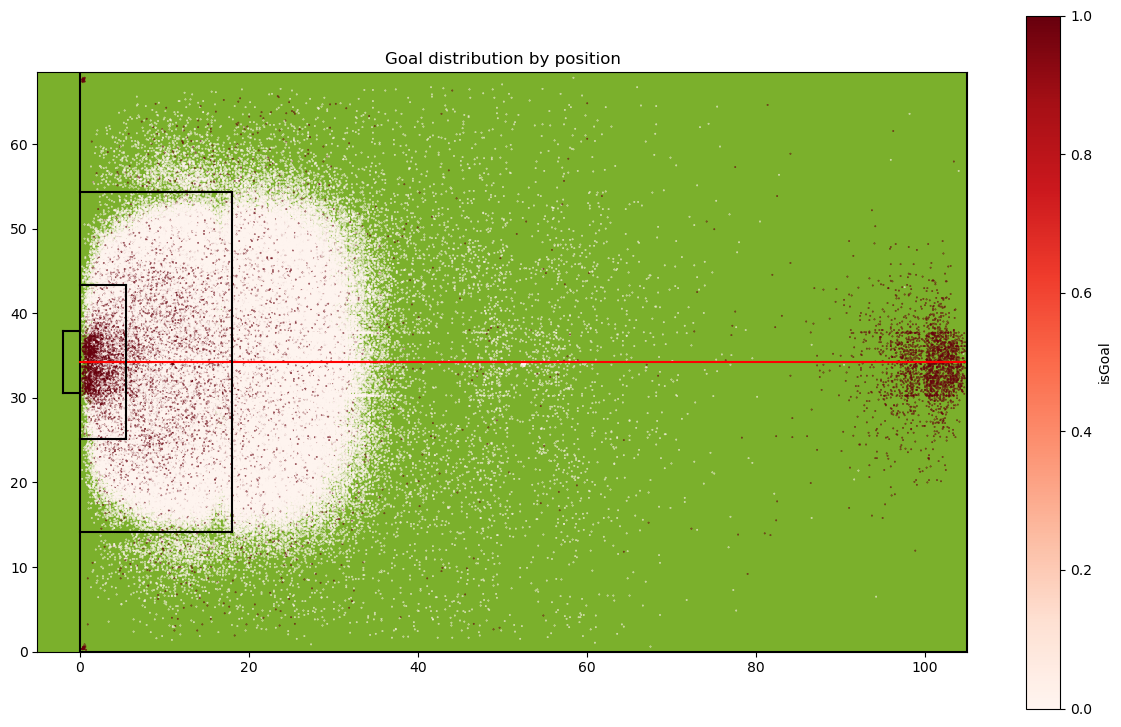

In [12]:
plt.figure(figsize=(15, 9))
# border
plt.plot([0, 0], [0, 68.5], 'k')
plt.plot([0, 105], [68.5, 68.5], 'k')
plt.plot([0, 105], [34.25, 34.25], 'k', c='r')
plt.plot([105, 105], [68.5, 0], 'k')
plt.plot([105, 0], [0, 0], 'k')
# goal
plt.plot([0, -2], [34.25 - 7.32 / 2, 34.25 - 7.32 / 2], 'k')
plt.plot([0, -2], [34.25 + 7.32 / 2, 34.25 + 7.32 / 2], 'k')
plt.plot([-2, -2], [34.25 - 7.32 / 2, 34.25 + 7.32 / 2], 'k')

# around
plt.plot([0, 5.5],  [34.25 - ( 5.5 + 7.32 / 2), 34.25 - ( 5.5 + 7.32 / 2)], 'k')
plt.plot([0, 5.5],  [34.25 + ( 5.5 + 7.32 / 2), 34.25 + ( 5.5 + 7.32 / 2)], 'k')
plt.plot([5.5, 5.5], [34.25 - ( 5.5 + 7.32 / 2), 34.25 + ( 5.5 + 7.32 / 2)], 'k')
# around
plt.plot([0, 18],  [34.25 - ( 5.5+11 + 7.32 / 2), 34.25 - ( 5.5+11 + 7.32 / 2)], 'k')
plt.plot([0, 18],  [34.25 + ( 5.5+11 + 7.32 / 2), 34.25 + ( 5.5+11 + 7.32 / 2)], 'k')
plt.plot([18, 18], [34.25 - ( 5.5+11 + 7.32 / 2), 34.25 + ( 5.5+11 + 7.32 / 2)], 'k')

plt.scatter(105-df['x'], df['y'], c=df_subset['eventType'], cmap='Reds', marker='o', s=0.1) # s = size of the dots, alpha = transparency

# show label
plt.title('Goal distribution by position')
plt.colorbar(label='isGoal')
# set plot backgroud to green
plt.xlim(-5, 105)
plt.ylim(0, 68.5)
plt.gca().set_facecolor('#7bb02c')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [13]:
df_subset_regular=feature_engineering(df_subset,False)
df_subset_catboost=feature_engineering(df_subset,True)

In [14]:
#dataset after preprocessing & feature_engineering
print("First few rows of the dataset:")
print((df_subset_regular.head()))
print("summary about the dataset after preprocessing & feature_engineering")
print(df_subset_regular.describe())

# Check for missing values in the entire dataset
print("Missing values per column:")
print(df_subset_regular.isna().sum())

First few rows of the dataset:
   min          x          y  situation  shotType  eventType  isBlocked  \
0    2  92.700000  30.340000          7         0          0      False   
1    3  78.655825  45.682293          5         3          0      False   
2    6  99.307018  35.525000          5         1          0       True   
3    6  97.956140  39.713095          5         3          0      False   
4   17  91.700000  40.553571          5         0          0      False   

   isOnTarget  isSavedOffLine      XDTGi     XATGi  position  footShot  
0       False           False  12.488218  0.626849         1         1  
1        True           False  29.458248  0.104990         0         1  
2        True           False   6.446757  3.146640         1         1  
3        True           False  10.081900  1.007250         1         1  
4        True           False  15.548312  0.391547         1         1  
summary about the dataset after preprocessing & feature_engineering
            

In [15]:
#catboost dataset after preprocessing & feature_engineering
print("First few rows of the dataset:")
print((df_subset_catboost.head()))

First few rows of the dataset:
   min          x          y        situation   shotType  eventType  \
0    2  92.700000  30.340000  ThrowInSetPiece     Header          0   
1    3  78.655825  45.682293      RegularPlay  RightFoot          0   
2    6  99.307018  35.525000      RegularPlay   LeftFoot          0   
3    6  97.956140  39.713095      RegularPlay  RightFoot          0   
4   17  91.700000  40.553571      RegularPlay     Header          0   

   isBlocked  isOnTarget  isSavedOffLine      XDTGi     XATGi position  \
0      False       False           False  12.488218  0.626849   middle   
1      False        True           False  29.458248  0.104990     left   
2       True        True           False   6.446757  3.146640   middle   
3      False        True           False  10.081900  1.007250   middle   
4      False        True           False  15.548312  0.391547   middle   

   footShot  
0         1  
1         1  
2         1  
3         1  
4         1  


In [16]:
print(df_subset_catboost.dtypes)

min                 int64
x                 float64
y                 float64
situation          object
shotType           object
eventType           int32
isBlocked            bool
isOnTarget           bool
isSavedOffLine       bool
XDTGi             float64
XATGi             float64
position           object
footShot            int64
dtype: object


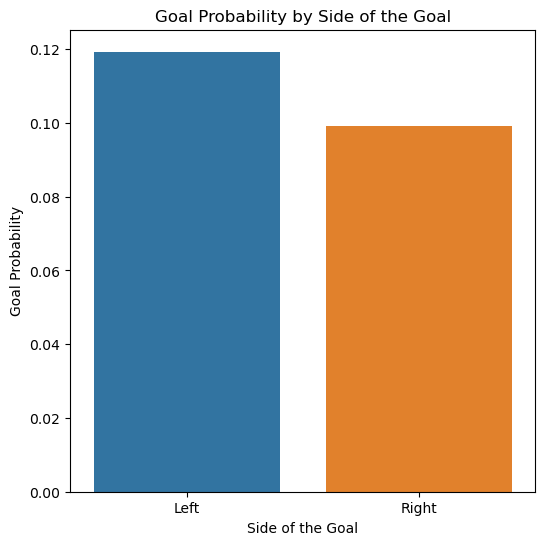

In [17]:
# plot the side of the shot ( left or right of the goal) vs the goal probability (use 'XXDTGi' and 'XATGi')

new_df = df_subset_regular[['x', 'y', 'eventType']].copy()
# make new column 'side' that is 1 if X is greater than 0.5 else 0
new_df['side'] = new_df['y'] >(68.5/2)
new_df['side'] = new_df['side'].replace({True:'Right', False:'Left'})
# drop X and Y columns
new_df = new_df.drop(['x', 'y'], axis=1)
# group by side and calculate the mean of isGoal
new_df = new_df.groupby('side').mean()
# plot the graph
plt.figure(figsize=(6, 6))
sns.barplot(x=new_df.index, y=new_df['eventType'])
plt.title('Goal Probability by Side of the Goal')
plt.xlabel('Side of the Goal')
plt.ylabel('Goal Probability')
plt.show()

C:\Users\adamf\AppData\Local\Temp\ipykernel_16024\2494800515.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot([0, 105], [34.25, 34.25], 'k', c='r')


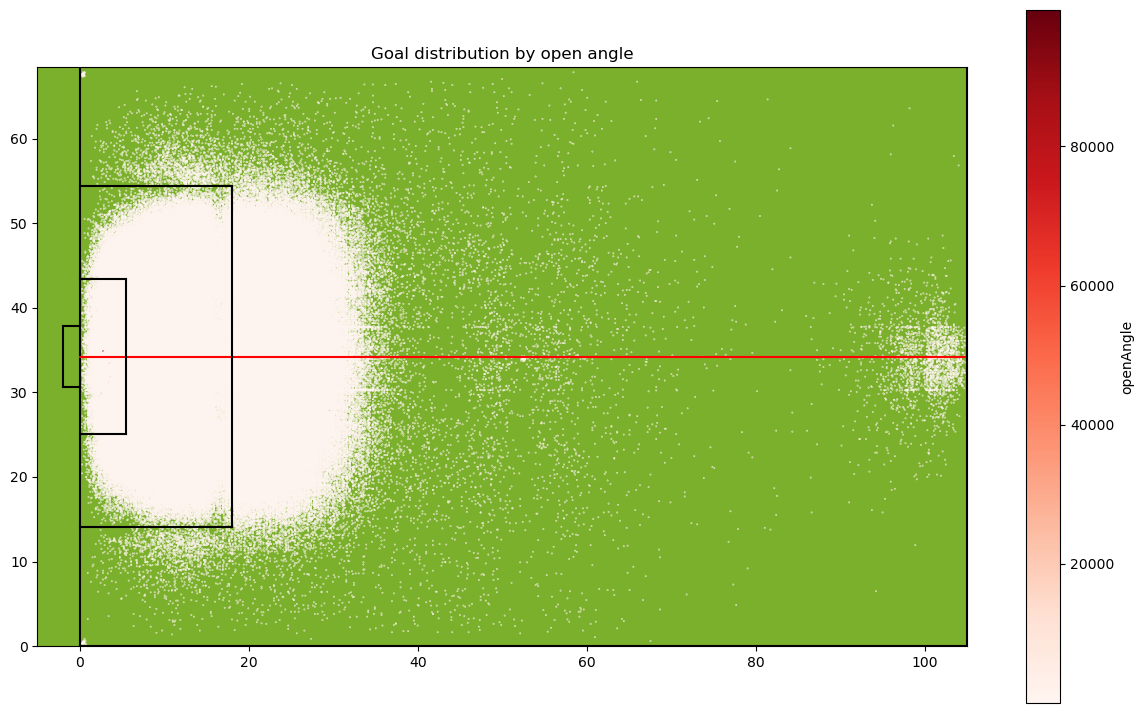

In [21]:
plt.figure(figsize=(15, 9))
# border
plt.plot([0, 0], [0, 68.5], 'k')
plt.plot([0, 105], [68.5, 68.5], 'k')
plt.plot([0, 105], [34.25, 34.25], 'k', c='r')
plt.plot([105, 105], [68.5, 0], 'k')
plt.plot([105, 0], [0, 0], 'k')
# goal
plt.plot([0, -2], [34.25 - 7.32 / 2, 34.25 - 7.32 / 2], 'k')
plt.plot([0, -2], [34.25 + 7.32 / 2, 34.25 + 7.32 / 2], 'k')
plt.plot([-2, -2], [34.25 - 7.32 / 2, 34.25 + 7.32 / 2], 'k')

# around
plt.plot([0, 5.5],  [34.25 - ( 5.5 + 7.32 / 2), 34.25 - ( 5.5 + 7.32 / 2)], 'k')
plt.plot([0, 5.5],  [34.25 + ( 5.5 + 7.32 / 2), 34.25 + ( 5.5 + 7.32 / 2)], 'k')
plt.plot([5.5, 5.5], [34.25 - ( 5.5 + 7.32 / 2), 34.25 + ( 5.5 + 7.32 / 2)], 'k')
# around
plt.plot([0, 18],  [34.25 - ( 5.5+11 + 7.32 / 2), 34.25 - ( 5.5+11 + 7.32 / 2)], 'k')
plt.plot([0, 18],  [34.25 + ( 5.5+11 + 7.32 / 2), 34.25 + ( 5.5+11 + 7.32 / 2)], 'k')
plt.plot([18, 18], [34.25 - ( 5.5+11 + 7.32 / 2), 34.25 + ( 5.5+11 + 7.32 / 2)], 'k')

plt.scatter(105-df_subset_catboost['x'],df_subset_catboost['y'], c=df_subset_regular['XATGi'], cmap='Reds', marker='o', s=0.1) # s = size of the dots, alpha = transparency

# show label
plt.title('Goal distribution by open angle')
plt.colorbar(label='openAngle')
# set plot backgroud to green
plt.xlim(-5, 105)
plt.ylim(0, 68.5)
plt.gca().set_facecolor('#7bb02c')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [25]:
# Define the features and target variable
X = df_subset_regular.drop('eventType', axis=1)  # Features
X_catboost=df_subset_catboost.drop('eventType', axis=1)
y = df_subset['eventType']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_catboost, X_test_catboost, y_train_catboost, y_test_catboost = train_test_split(X_catboost, y, test_size=0.2, random_state=42)


In [26]:
# Display the shapes of the train and test sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (546162, 12)
Shape of X_test: (136541, 12)
Shape of y_train: (546162,)
Shape of y_test: (136541,)


In [27]:
print(y_train.unique())
print(y_train.dtype)

[0 1]
int32


In [28]:
# Convert object-type columns to string type in X_train_catboost and X_test_catboost
#X_train_catboost = X_train_catboost.astype(str)
#X_test_catboost = X_test_catboost.astype(str)

In [29]:
print(X_train_catboost.dtypes)

min                 int64
x                 float64
y                 float64
situation          object
shotType           object
isBlocked            bool
isOnTarget           bool
isSavedOffLine       bool
XDTGi             float64
XATGi             float64
position           object
footShot            int64
dtype: object


<Axes: ylabel='count'>

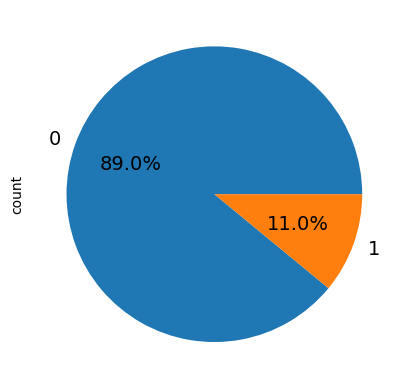

In [30]:
#target distribution
y_test_catboost.value_counts().plot.pie(autopct='%1.1f%%',textprops={'fontsize': 14})

In [31]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_catboost), y= y_train_catboost)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [32]:
class_weights_dict

{0: 0.5613302664602899, 1: 4.576290784777035}

In [33]:
# Convert categorical features to string type in the train and test pools
#['h_team', 'a_team', 'situation', 'shotType', 'lastAction','position']
train_pool = Pool(data=X_train_catboost, label=y_train_catboost, cat_features=[ 'situation', 'shotType','position'], feature_names=list(X_train_catboost.columns))
test_pool = Pool(data=X_test_catboost, label=y_test_catboost, cat_features=[ 'situation', 'shotType','position'], feature_names=list(X_test_catboost.columns))


In [34]:
#Balancing the train dataset
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the labels
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [35]:
# Initialize models
rf_model = RandomForestClassifier()
catboost_model = CatBoostClassifier()
xgboost_model = XGBClassifier()
lgbm_model = LGBMClassifier()
adaboost_model = AdaBoostClassifier()


In [36]:
# Train models
rf_model.fit(X_train_balanced, y_train_balanced)
catboost_model.fit(train_pool)
xgboost_model.fit(X_train_balanced, y_train_balanced)
lgbm_model.fit(X_train_balanced, y_train_balanced)
adaboost_model.fit(X_train_balanced, y_train_balanced)

# Predict probabilities using trained models
rf_probabilities = rf_model.predict_proba(X_test)
catboost_probabilities = catboost_model.predict_proba(test_pool)
xgboost_probabilities = xgboost_model.predict_proba(X_test)
lgbm_probabilities = lgbm_model.predict_proba(X_test)
adaboost_probabilities = adaboost_model.predict_proba(X_test)

Learning rate set to 0.151974
0:	learn: 0.3570995	total: 397ms	remaining: 6m 36s
1:	learn: 0.2523757	total: 625ms	remaining: 5m 11s
2:	learn: 0.2177681	total: 847ms	remaining: 4m 41s
3:	learn: 0.2031665	total: 1.09s	remaining: 4m 30s
4:	learn: 0.1956673	total: 1.32s	remaining: 4m 22s
5:	learn: 0.1907639	total: 1.57s	remaining: 4m 20s
6:	learn: 0.1870678	total: 1.79s	remaining: 4m 13s
7:	learn: 0.1849721	total: 2s	remaining: 4m 7s
8:	learn: 0.1834603	total: 2.21s	remaining: 4m 3s
9:	learn: 0.1821840	total: 2.41s	remaining: 3m 58s
10:	learn: 0.1808336	total: 2.63s	remaining: 3m 56s
11:	learn: 0.1800281	total: 2.84s	remaining: 3m 53s
12:	learn: 0.1795268	total: 3.05s	remaining: 3m 51s
13:	learn: 0.1787071	total: 3.27s	remaining: 3m 50s
14:	learn: 0.1779694	total: 3.48s	remaining: 3m 48s
15:	learn: 0.1773646	total: 3.71s	remaining: 3m 48s
16:	learn: 0.1770304	total: 3.89s	remaining: 3m 45s
17:	learn: 0.1766237	total: 4.1s	remaining: 3m 43s
18:	learn: 0.1762966	total: 4.32s	remaining: 3m 43

In [37]:
# Evaluate models (using validation data or cross-validation)

(X_val, y_val)=(X_test,y_test)

# Evaluate RandomForestClassifier
rf_accuracy = rf_model.score(X_val, y_val)
# Evaluate CatBoostClassifier
catboost_accuracy = catboost_model.score(test_pool)
# Evaluate XGBClassifier
xgboost_accuracy = xgboost_model.score(X_val, y_val)
# Evaluate LGBMClassifier
lgbm_accuracy = lgbm_model.score(X_val, y_val)
# Evaluate AdaBoostClassifier
adaboost_accuracy = adaboost_model.score(X_val, y_val)

# Print model accuracies
print("RandomForestClassifier Accuracy:", rf_accuracy)
print("CatBoostClassifier Accuracy:", catboost_accuracy)
print("XGBClassifier Accuracy:", xgboost_accuracy)
print("LGBMClassifier Accuracy:", lgbm_accuracy)
print("AdaBoostClassifier Accuracy:", adaboost_accuracy)


RandomForestClassifier Accuracy: 0.8737375586820076
CatBoostClassifier Accuracy: 0.917101822895687
XGBClassifier Accuracy: 0.8415494247149208
LGBMClassifier Accuracy: 0.836708387956731
AdaBoostClassifier Accuracy: 0.8179301455240551


In [38]:
# Evaluate RandomForestClassifier
rf_mse = mean_squared_error(y_test, rf_probabilities[:, 1])
rf_error = 1 - rf_accuracy
print("RandomForestClassifier MSE:", rf_mse)
print("RandomForestClassifier Error:", rf_error)

# Evaluate CatBoostClassifier
catboost_mse = mean_squared_error(y_test, catboost_probabilities[:, 1])
catboost_error = 1 - catboost_accuracy
print("CatBoostClassifier MSE:", catboost_mse)
print("CatBoostClassifier Error:", catboost_error)

# Evaluate XGBClassifier
xgboost_mse = mean_squared_error(y_test, xgboost_probabilities[:, 1])
xgboost_error = 1 - xgboost_accuracy
print("XGBClassifier MSE:", xgboost_mse)
print("XGBClassifier Error:", xgboost_error)

# Evaluate LGBMClassifier
lgbm_mse = mean_squared_error(y_test, lgbm_probabilities[:, 1])
lgbm_error = 1 - lgbm_accuracy
print("LGBMClassifier MSE:", lgbm_mse)
print("LGBMClassifier Error:", lgbm_error)

# Evaluate AdaBoostClassifier
adaboost_mse = mean_squared_error(y_test, adaboost_probabilities[:,1])
adaboost_error = 1 - adaboost_accuracy
print("AdaBoostClassifier MSE:", adaboost_mse)
print("AdaBoostClassifier Error:", adaboost_error)


RandomForestClassifier MSE: 0.08219702421256125
RandomForestClassifier Error: 0.12626244131799236
CatBoostClassifier MSE: 0.05695145418330244
CatBoostClassifier Error: 0.08289817710431302
XGBClassifier MSE: 0.09997193103272878
XGBClassifier Error: 0.15845057528507922
LGBMClassifier MSE: 0.10110523940847672
LGBMClassifier Error: 0.16329161204326903
AdaBoostClassifier MSE: 0.19325100235926934
AdaBoostClassifier Error: 0.18206985447594493


In [39]:
def evaluation(model,x_train,x_test,y_train,y_test):
    predictions = model.predict(x_test)
    train_pred = model.predict(x_train)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    conf_matrix = confusion_matrix(y_test, predictions)
    train_accuracy = model.score(x_train , y_train)
    train_f1 = f1_score(train_pred , y_train,average='macro')
    print('Train:')
    print("Accuracy:", train_accuracy)
    print("F1 Score:", train_f1)
    print("*"*20)
    print('Test:')
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(conf_matrix)

In [40]:
def distribution(model):
    pred=model.predict_proba(XXX)
    p=pd.Series(pred[:,1])
    ind=p.index
    inter=ind.intersection(X.index)
    xG=np.array(X.loc[inter][["expectedGoals"]]).flatten()
    a =  pd.DataFrame({'footmob_xg': xG, 'model_xg': p[inter]})
    plt.figure()
    sns.boxenplot(a)
    plt.figure()
    sns.histplot(a[a['footmob_xg']>0.1]['footmob_xg'],label='footmob_xg')
    sns.histplot(a[a['model_xg']>0.1]['model_xg'],label='model_xg')
    plt.legend()
    plt.xlabel('Distribution > 0.1')
    return xG , p[inter]

In [41]:
X=preprocess(df,True)
XX=preprocess(df,False)
XXX=feature_engineering(XX,True)
X.dropna(inplace=True)
XXX.drop(["eventType"],inplace=True,axis=1)

In [42]:
footmob_predictions = X['expectedGoals']>0.5
print("This is the used xg in other sites :")
print(f1_score(X['eventType'], footmob_predictions, average='macro'))

This is the used xg in other sites :
0.6546439508146185


In [58]:
weights = {}
weights[0] = 1.8
weights[1] = 3.2

In [59]:
categorical_cols=[ 'situation', 'shotType','position']

In [60]:
model = CatBoostClassifier(cat_features=categorical_cols,class_weights=weights)
model.fit(X_train_catboost,y_train_catboost)

Learning rate set to 0.151974
0:	learn: 0.3901964	total: 270ms	remaining: 4m 29s
1:	learn: 0.2963901	total: 546ms	remaining: 4m 32s
2:	learn: 0.2634069	total: 809ms	remaining: 4m 28s
3:	learn: 0.2496043	total: 1.05s	remaining: 4m 20s
4:	learn: 0.2425075	total: 1.3s	remaining: 4m 18s
5:	learn: 0.2372923	total: 1.56s	remaining: 4m 18s
6:	learn: 0.2340022	total: 1.82s	remaining: 4m 18s
7:	learn: 0.2320129	total: 2.06s	remaining: 4m 16s
8:	learn: 0.2302191	total: 2.3s	remaining: 4m 13s
9:	learn: 0.2289342	total: 2.53s	remaining: 4m 10s
10:	learn: 0.2275819	total: 2.78s	remaining: 4m 10s
11:	learn: 0.2266103	total: 3.01s	remaining: 4m 8s
12:	learn: 0.2257968	total: 3.24s	remaining: 4m 5s
13:	learn: 0.2249498	total: 3.46s	remaining: 4m 3s
14:	learn: 0.2242984	total: 3.69s	remaining: 4m 2s
15:	learn: 0.2234341	total: 3.96s	remaining: 4m 3s
16:	learn: 0.2229384	total: 4.22s	remaining: 4m 4s
17:	learn: 0.2223504	total: 4.47s	remaining: 4m 4s
18:	learn: 0.2219448	total: 4.7s	remaining: 4m 2s
19:

In [61]:
evaluation(model,X_train_catboost,X_test_catboost,y_train_catboost,y_test_catboost)

Train:
Accuracy: 0.9144246578853893
F1 Score: 0.7890600333454569
********************
Test:
Accuracy: 0.9087380347294952
Precision: 0.765364966389312
Recall: 0.7874200785996623
F1 Score: 0.7757407601647839
Confusion Matrix:
[[114615   6950]
 [  5511   9465]]


c:\Users\adamf\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\adamf\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\adamf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\adamf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before ope

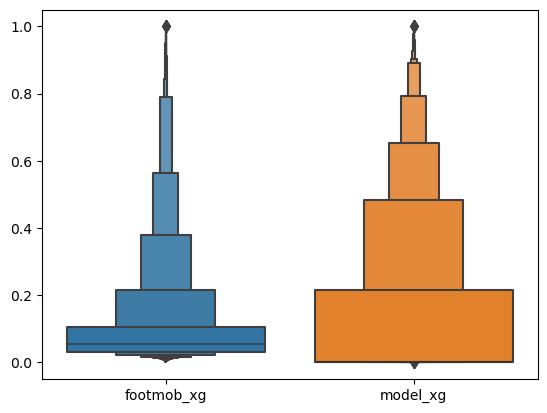

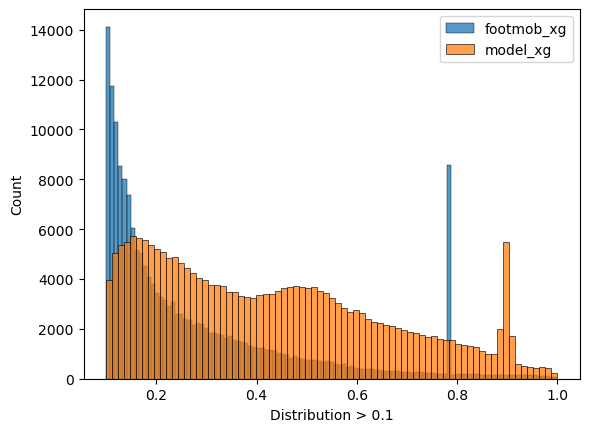

In [62]:
footmob_xg , model_xg = distribution(model)